## Post-analysis SpaceM QC of keratocytes pilot 

In [1]:
options(stringsAsFactors = FALSE, 
        warn = -1,
        repr.plot.width=12, repr.plot.height=7)


In [2]:
library(ggplot2)
library(ggbeeswarm)
library(data.table)
library(funprog)
library(dplyr)
options(dplyr.summarise.inform = FALSE)
library(sp)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### loading datafiles

In [3]:
files <- list.files(pattern = "spatiomolecular_matrix.csv", recursive = T)
files <- files[grepl("ablation_mark_analysis",files)]

abl_matrix <-   lapply(files, function(i) {
                        df <- fread(i)
                        df$well <- regmatches(i, regexpr("W\\d", i))
                        return(df)
                      })

metab <-
  lapply(abl_matrix, function(i) {
    colnames(i)[grepl("^C\\d",   colnames(i))]
    })

all_metab <- unique(unlist(metab))

meta_matrix <- 
  sapply(metab, function(i){
    all_metab %in% i
  })

colnames(meta_matrix) <- regmatches(files, regexpr("W\\d", files))
meta_matrix <- meta_matrix[order(rowSums(meta_matrix), decreasing = T),]

meta_matrix_long <- melt(meta_matrix, varnames = c("molecule","well"), value.name = "found")
meta_matrix_long$found <- factor(ifelse(meta_matrix_long$found, "present","not present"), 
                                 levels = c("present","not present"))
abl_matrix_colnames <-
Reduce(intersect,
       lapply(abl_matrix, function(i){colnames(i)}))

abl_matrix <-
do.call("rbind",lapply(abl_matrix, function(i){
  i[,..abl_matrix_colnames]
}))

ablation_distance_in_px <- mean(diff(abl_matrix$center_y[1:30]))
ablation_distance_in_um <- 25
px_per_um <- ablation_distance_in_px / ablation_distance_in_um

files <- list.files(pattern = "spatiomolecular_matrix.csv", recursive = T)
files <- files[grepl("single_cell_analysis",files)]

sc_matrix <-   lapply(files, function(i) {
  df <- fread(i)
  df$well <- regmatches(i, regexpr("W\\d", i))
  return(df)
})
sc_matrix_colnames <-
  Reduce(intersect,
         lapply(sc_matrix, function(i){colnames(i)}))

sc_matrix <-
  do.call("rbind",lapply(sc_matrix, function(i){
    i[,..sc_matrix_colnames]
  }))



### some QC figures

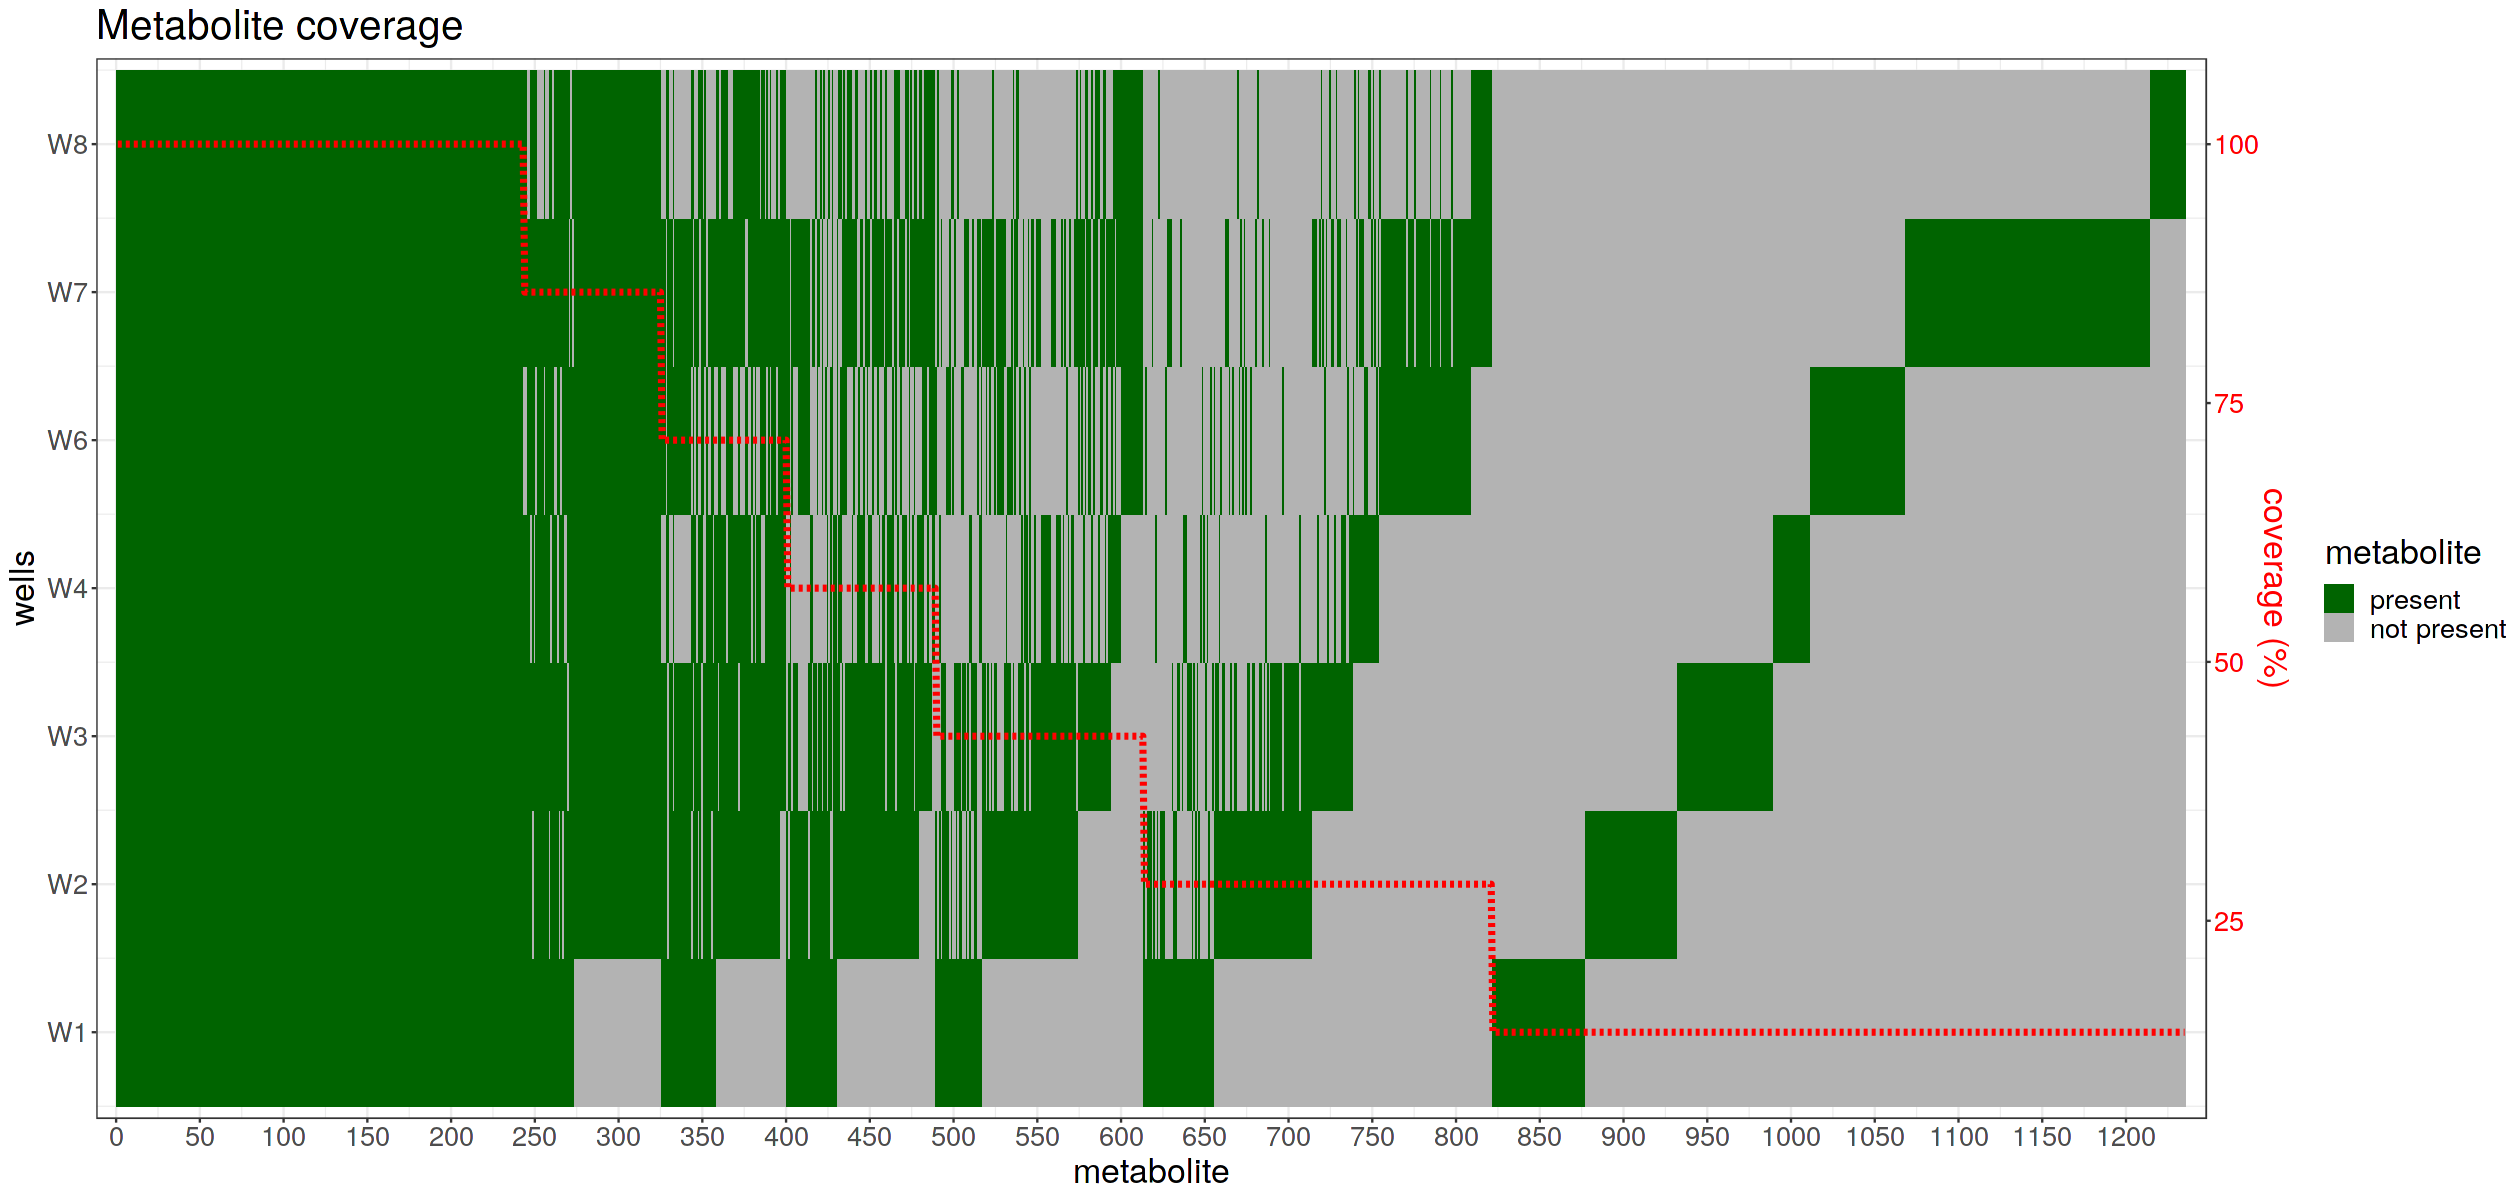

In [4]:
options(repr.plot.width=21, repr.plot.height=10)
 
ggplot(meta_matrix_long, aes(x = molecule, y = as.numeric(well)))+
  geom_tile(aes(fill = found))+
  geom_line(data = data.frame(lipid = 1:dim(meta_matrix)[1],
                              cumsum = rowSums(meta_matrix)),
            aes(x = lipid, y = cumsum), color = "red", linetype = 2, size = 1.5)+
  scale_x_continuous(breaks = seq(from = 0, to = 1500,by = 50), expand = c(0.01,0.01))+
  scale_y_continuous(breaks = 1:7, name = "wells",  expand = c(0.01,0.01),
                     labels = colnames(meta_matrix), 
                     sec.axis = sec_axis(trans = ~. / 7 * 100, name = "coverage (%)",
                                         breaks = seq(from = 0, to = 100, by = 25)))+
  scale_fill_manual(values = c("darkgreen","gray70"))+
  labs(title = "Metabolite coverage", x = "metabolite", fill = "metabolite")+
  theme_bw()+
  theme(axis.text.y.right = element_text(colour = "red"), axis.title.y.right = element_text(colour = "red"))+
  theme(text = element_text(size = 20))

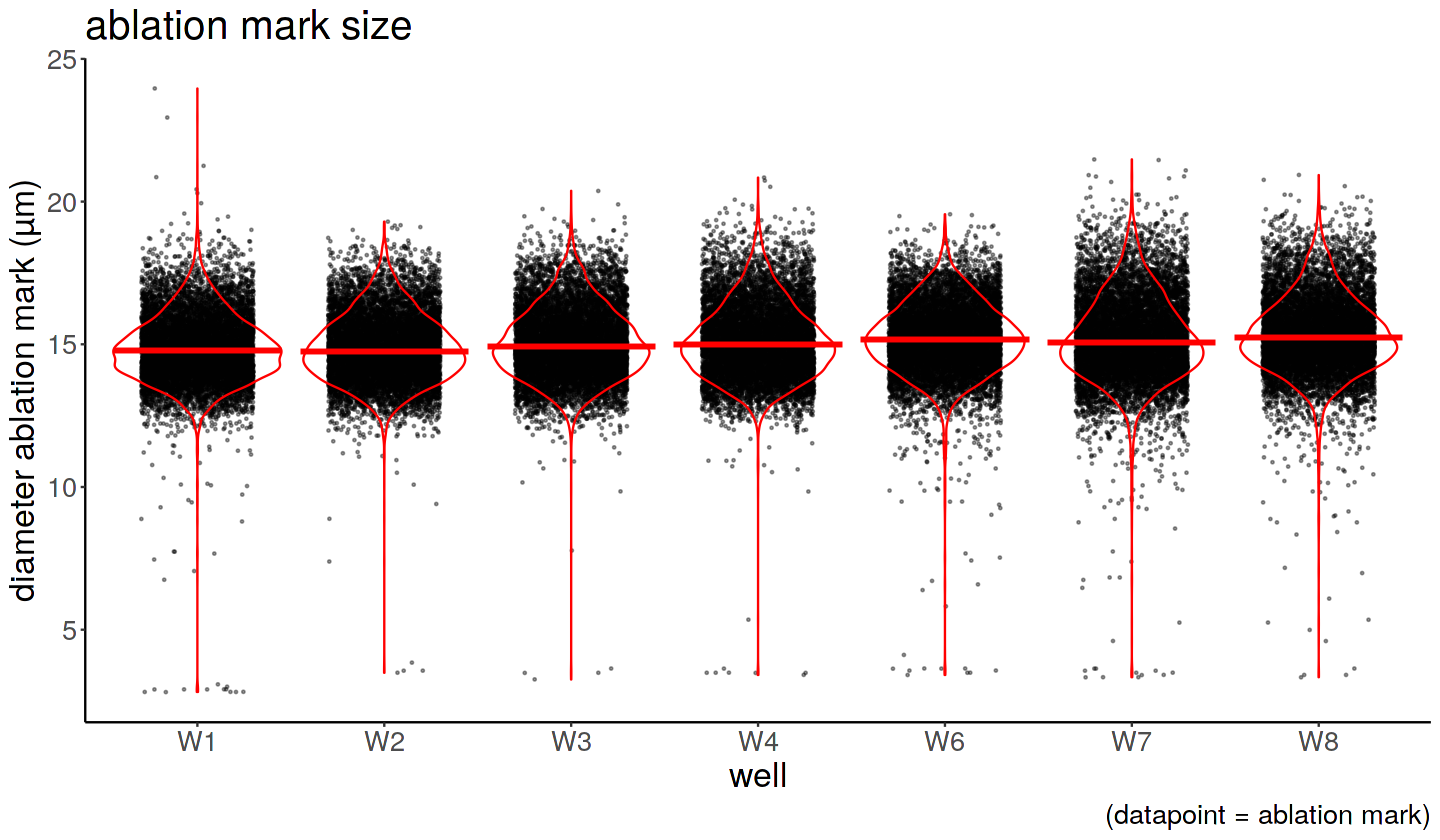

In [5]:
options(repr.plot.width=12, repr.plot.height=7)

ggplot(data = abl_matrix, aes(x = well, 
                              y = (2*sqrt((am_area )/pi))/ px_per_um  ))+
  labs(title = "ablation mark size", y = "diameter ablation mark (µm)", caption = "(datapoint = ablation mark)")+
  geom_jitter(alpha = .4, size = .3, width = .3)+
  stat_summary(fun="median",geom="crossbar", col = "red")+
  geom_violin(col = "red", fill = NA)+
  theme_classic()+
  theme(text = element_text(size = 20))

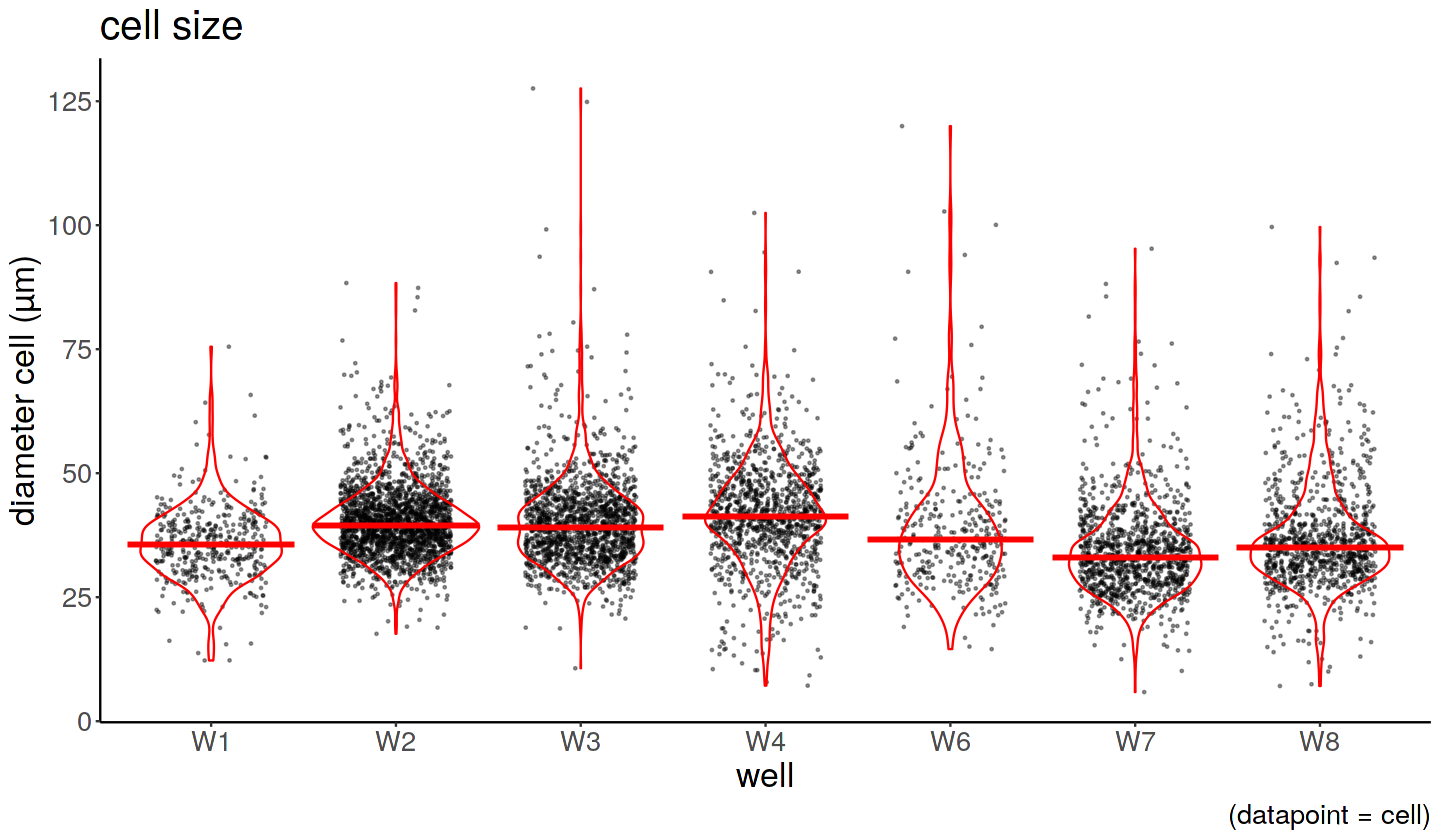

In [6]:
ggplot(data = sc_matrix, aes(x = well, 
                             y = (2*sqrt((cell_area )/pi))/ px_per_um  ))+
  labs(title = "cell size", y = "diameter cell (µm)", caption = "(datapoint = cell)")+
  geom_jitter(alpha = .4, size = .3, width = .3)+
  stat_summary(fun="median",geom="crossbar", col = "red")+
  geom_violin(col = "red", fill = NA)+
  theme_classic()+
  theme(text = element_text(size = 20))

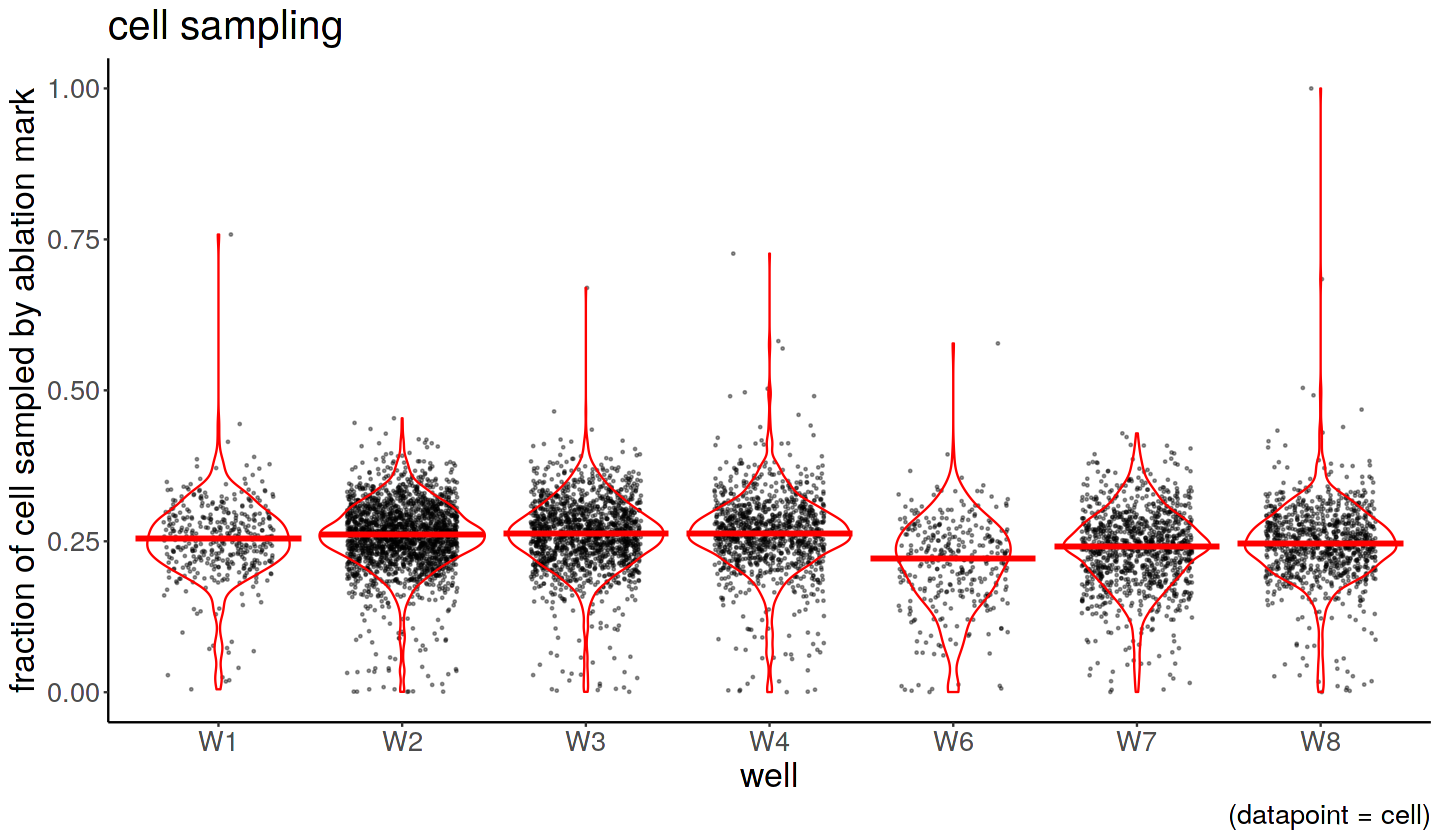

In [7]:
ggplot(data = sc_matrix, aes(x = well, y = cell_sampling_ratio))+
  labs(title = "cell sampling", y = "fraction of cell sampled by ablation mark", caption = "(datapoint = cell)")+
  geom_jitter(alpha = .4, size = .3, width = .3)+
  stat_summary(fun="median",geom="crossbar", col = "red")+
  geom_violin(col = "red", fill = NA)+
  theme_classic()+
  theme(text = element_text(size = 20))

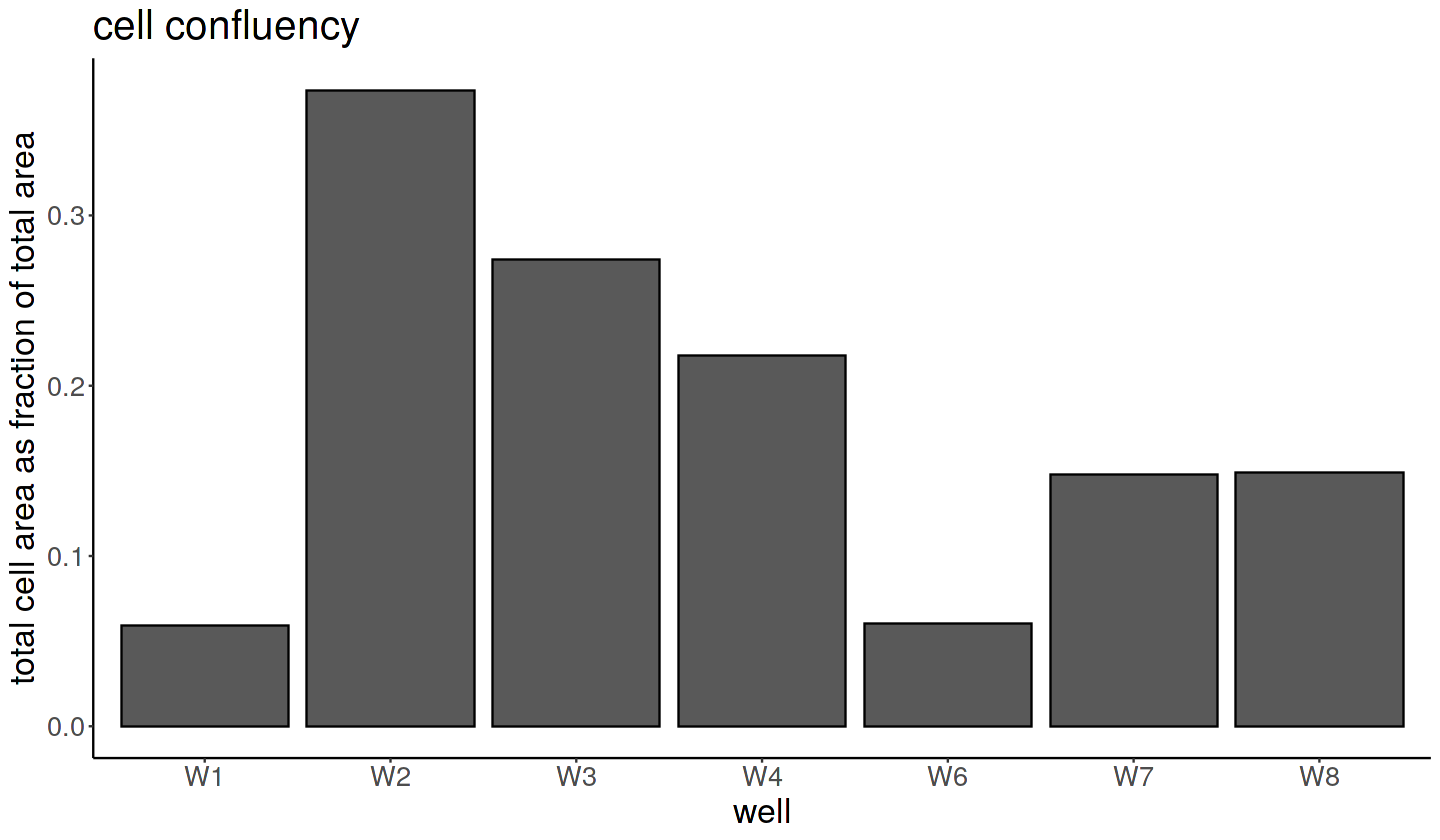

In [8]:
ggplot(data = sc_matrix %>% group_by(well) %>%
  summarise(total_cell_area = sum(cell_area, na.rm = T),
            total_cell_area_fraction = sum(cell_area, na.rm = T) / 
              (diff(range(abl_matrix$center_x)) * diff(range(abl_matrix$center_y)))
              ), aes(x = well, y = total_cell_area_fraction))+
  geom_bar(stat = "identity", col = "black")+
  labs(title = "cell confluency", y = "total cell area as fraction of total area")+
  theme_classic()+
  theme(text = element_text(size = 20))

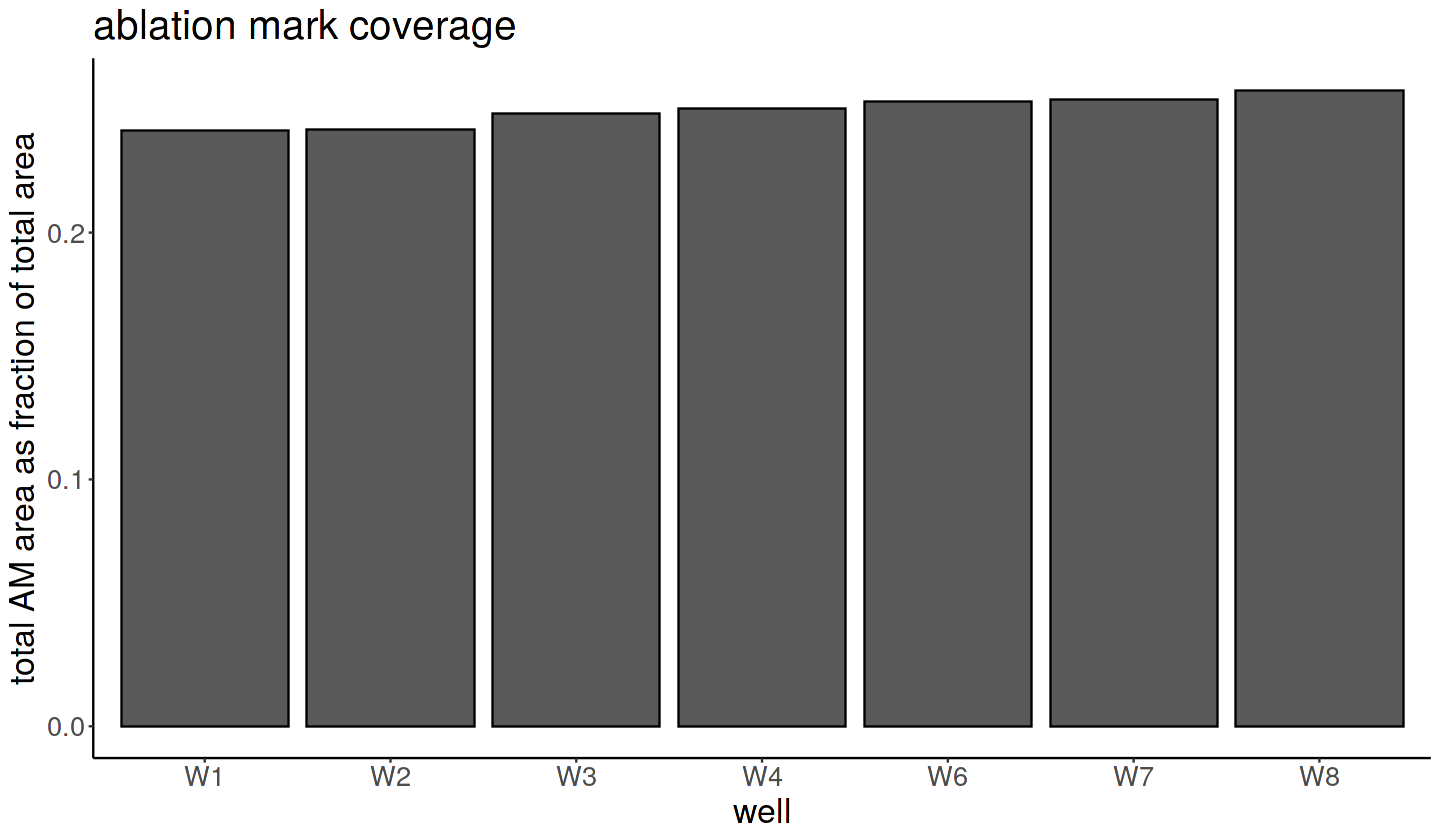

In [9]:
ggplot(data = abl_matrix %>% group_by(well) %>%
         summarise(total_cell_area = sum(am_area, na.rm = T),
                   total_cell_area_fraction = sum(am_area, na.rm = T) / 
                     (diff(range(abl_matrix$center_x)) * diff(range(abl_matrix$center_y)))
         ), aes(x = well, y = total_cell_area_fraction))+
  geom_bar(stat = "identity", col = "black")+
  labs(title = "ablation mark coverage", y = "total AM area as fraction of total area")+
  theme_classic()+
  theme(text = element_text(size = 20))

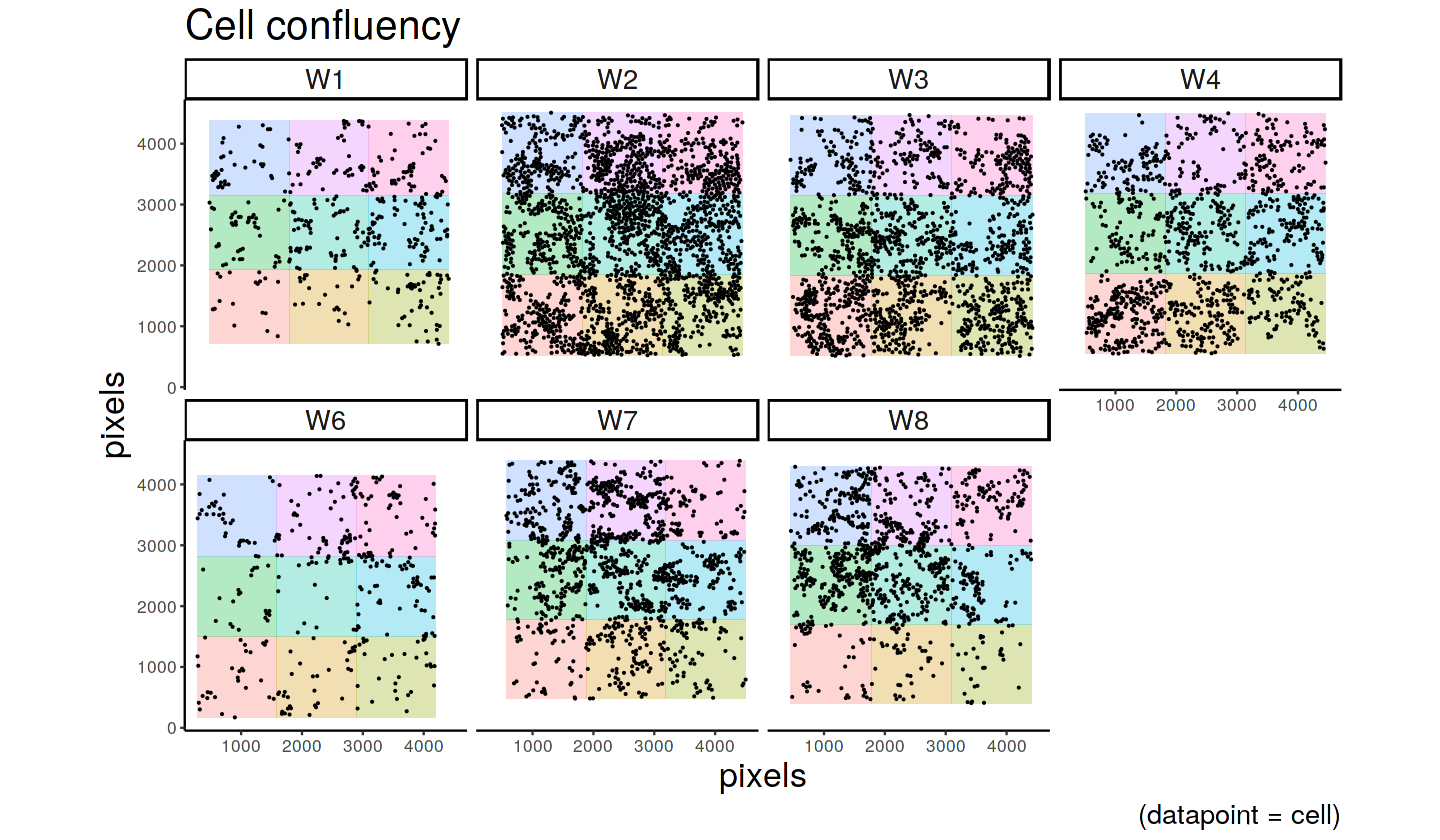

In [10]:
sc_matrix_tiles <- sc_matrix %>% group_by(well) %>% summarise(xmin = rep(min(center_x) + diff(range(center_x))*c(0/3,1/3,2/3),3),
                                           xmax = rep(min(center_x) + diff(range(center_x))*c(1/3,2/3,1), 3),
                                           ymin = min(center_y) + diff(range(center_y))*c(rep(0/3,3),
                                                                                          rep(1/3,3),
                                                                                          rep(2/3,3)),
                                           ymax = min(center_y) + diff(range(center_y))*c(rep(1/3,3),
                                                                                          rep(2/3,3),
                                                                                          rep(1,3))
                                           )

sc_matrix_tiles$tile <- rep(paste0("s",1:9),7)


ggplot(sc_matrix_tiles, aes(fill = tile))+
  geom_rect(aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax=ymax), alpha = .3, show.legend = F)+
  geom_point(data = sc_matrix, aes(x = center_x, y = center_y), fill = NA, size = .1)+
  facet_wrap(~well, ncol = 4)+
  coord_fixed()+
  labs(x = "pixels",y = "pixels", title = "Cell confluency", caption = "(datapoint = cell)")+
  theme_classic()+
  theme(text = element_text(size = 20), axis.text = element_text(size = 10))

In [11]:
sc_matrix_tiles$well_tile <- paste0(sc_matrix_tiles$well,"#",sc_matrix_tiles$tile)


sc_matrix$tile <-
sapply(seq_along(sc_matrix$cell_id), function(cell_i){
  (sc_matrix_tiles %>% filter(well == sc_matrix[cell_i,]$well)%>% pull(well_tile))[
  sc_matrix_tiles %>% filter(well == sc_matrix[cell_i,]$well) %>% pull(xmin) < sc_matrix[cell_i,]$center_x &
    sc_matrix_tiles %>% filter(well == sc_matrix[cell_i,]$well) %>% pull(xmax) > sc_matrix[cell_i,]$center_x &
    sc_matrix_tiles %>% filter(well == sc_matrix[cell_i,]$well) %>% pull(ymin) < sc_matrix[cell_i,]$center_y &
    sc_matrix_tiles %>% filter(well == sc_matrix[cell_i,]$well) %>% pull(ymax) > sc_matrix[cell_i,]$center_y][1]
})



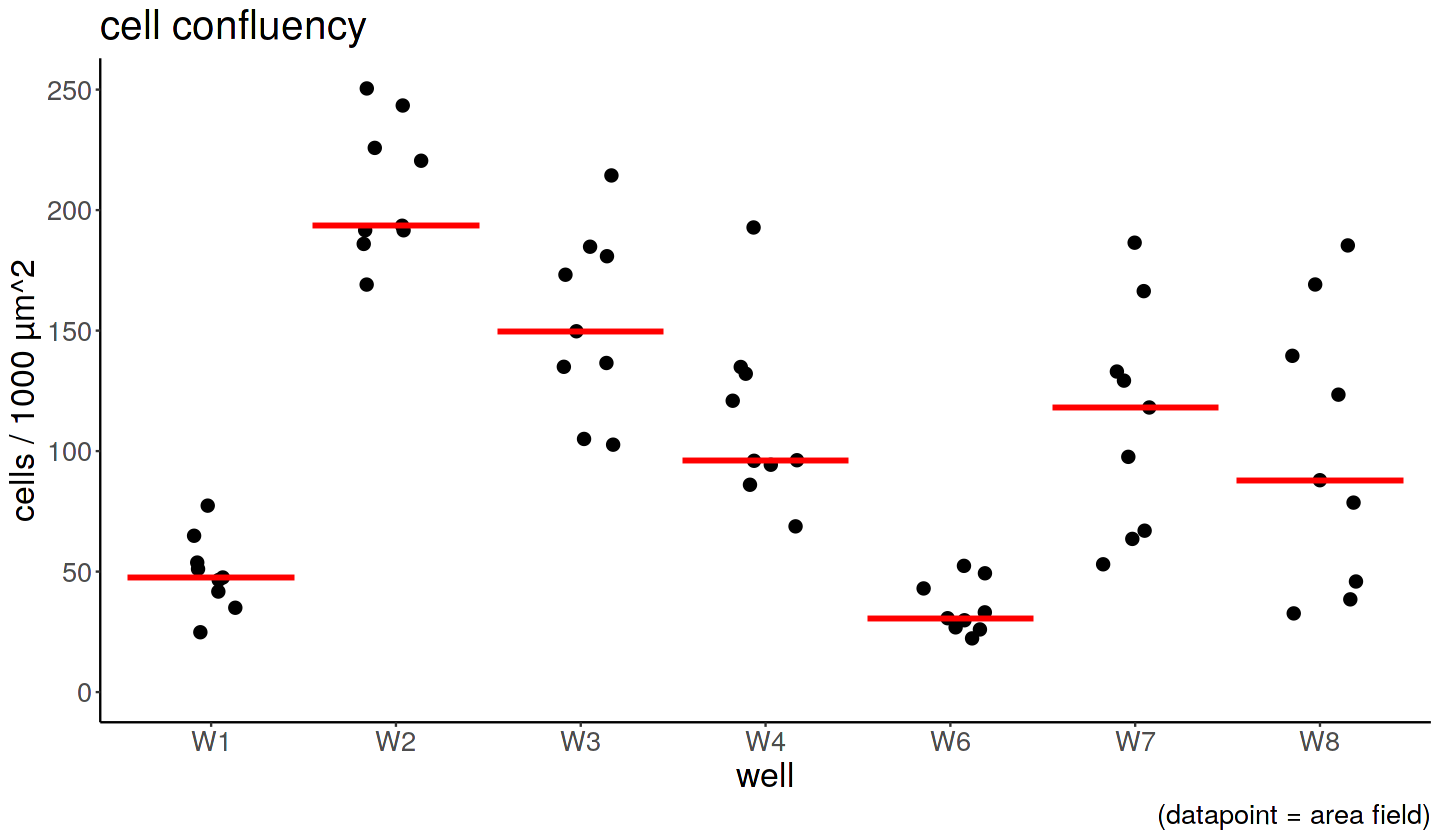

In [12]:
sc_matrix_confl <- sc_matrix %>% group_by(well, tile) %>% 
  summarise(n = length(cell_id) ,
            density = 10^6 * length(cell_id)/ 
              (diff(range(center_x)) * diff(range(center_y)) * (1/px_per_um)  )
            )

sc_matrix_confl <- sc_matrix_confl[!is.na(sc_matrix_confl$tile),]

ggplot(data = sc_matrix_confl, aes(x = well, y = density))+
  scale_y_continuous(limits = c(0,NA))+
  labs(title = "cell confluency", y = "cells / 1000 µm^2", caption = "(datapoint = area field)")+
  geom_jitter(width = .2, size = 3)+
  stat_summary(fun="median",geom="crossbar", col = "red")+
  theme_classic()+
  theme(text = element_text(size = 20))

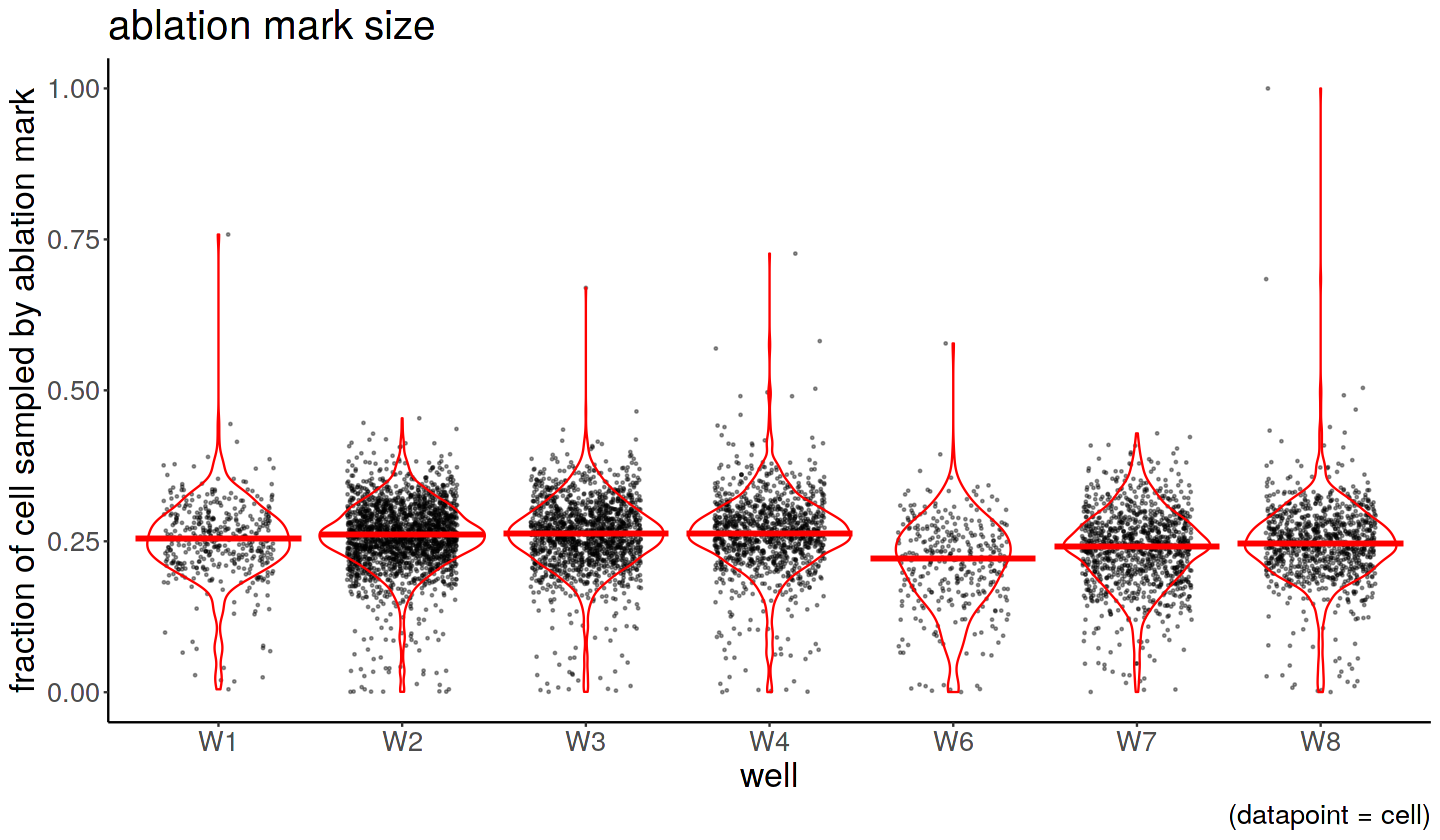

In [13]:
ggplot(data = sc_matrix, aes(x = well, y = cell_sampling_ratio))+
  labs(title = "ablation mark size", y = "fraction of cell sampled by ablation mark", 
       caption = "(datapoint = cell)")+
  geom_jitter(alpha = .4, size = .3, width = .3)+
  stat_summary(fun="median",geom="crossbar", col = "red")+
  geom_violin(col = "red", fill = NA)+
  theme_classic()+
  theme(text = element_text(size = 20))

In [14]:
abl_matrix_long <- abl_matrix[,c(1,6,16:259)] %>% 
  tidyr::pivot_longer(colnames(abl_matrix)[16:258], names_to = "formula_adduct", values_to = "signal" )


formula_adduct_cell_signals <-
  abl_matrix_long %>% filter(am_sampling_ratio %in% c(0, 1)) %>%
  group_by(well, formula_adduct)  %>% summarise(
    zeros = mean(signal[am_sampling_ratio == 0]),
    ones = mean(signal[am_sampling_ratio == 1]),
    s_n = mean(signal[am_sampling_ratio == 1]) / mean(signal[am_sampling_ratio == 0]),
    p_values = 
      wilcox.test(
        x = signal[am_sampling_ratio == 1],
        y = signal[am_sampling_ratio == 0],
        alternative = "greater"
      )$p.value
    
  )

formula_adduct_cell_signals$p_values <- p.adjust(formula_adduct_cell_signals$p_values, method = "fdr")
formula_adduct_cell_signals$p_values  <- -log(base = 10, formula_adduct_cell_signals$p_values )

formula_adduct_cell_signals$p_values[is.infinite(formula_adduct_cell_signals$p_values)] <- 300
formula_adduct_cell_signals$s_n[is.infinite(formula_adduct_cell_signals$s_n)] <- NA

formula_adduct_cell_signals$formula_adduct <-
  factor(formula_adduct_cell_signals$formula_adduct, levels = formula_adduct_cell_signals %>% group_by(formula_adduct) %>% summarise(mean = mean(s_n, na.rm = T)) %>% 
           arrange(desc(mean)) %>% pull(formula_adduct))

## Selecting intra-cellular metabolites

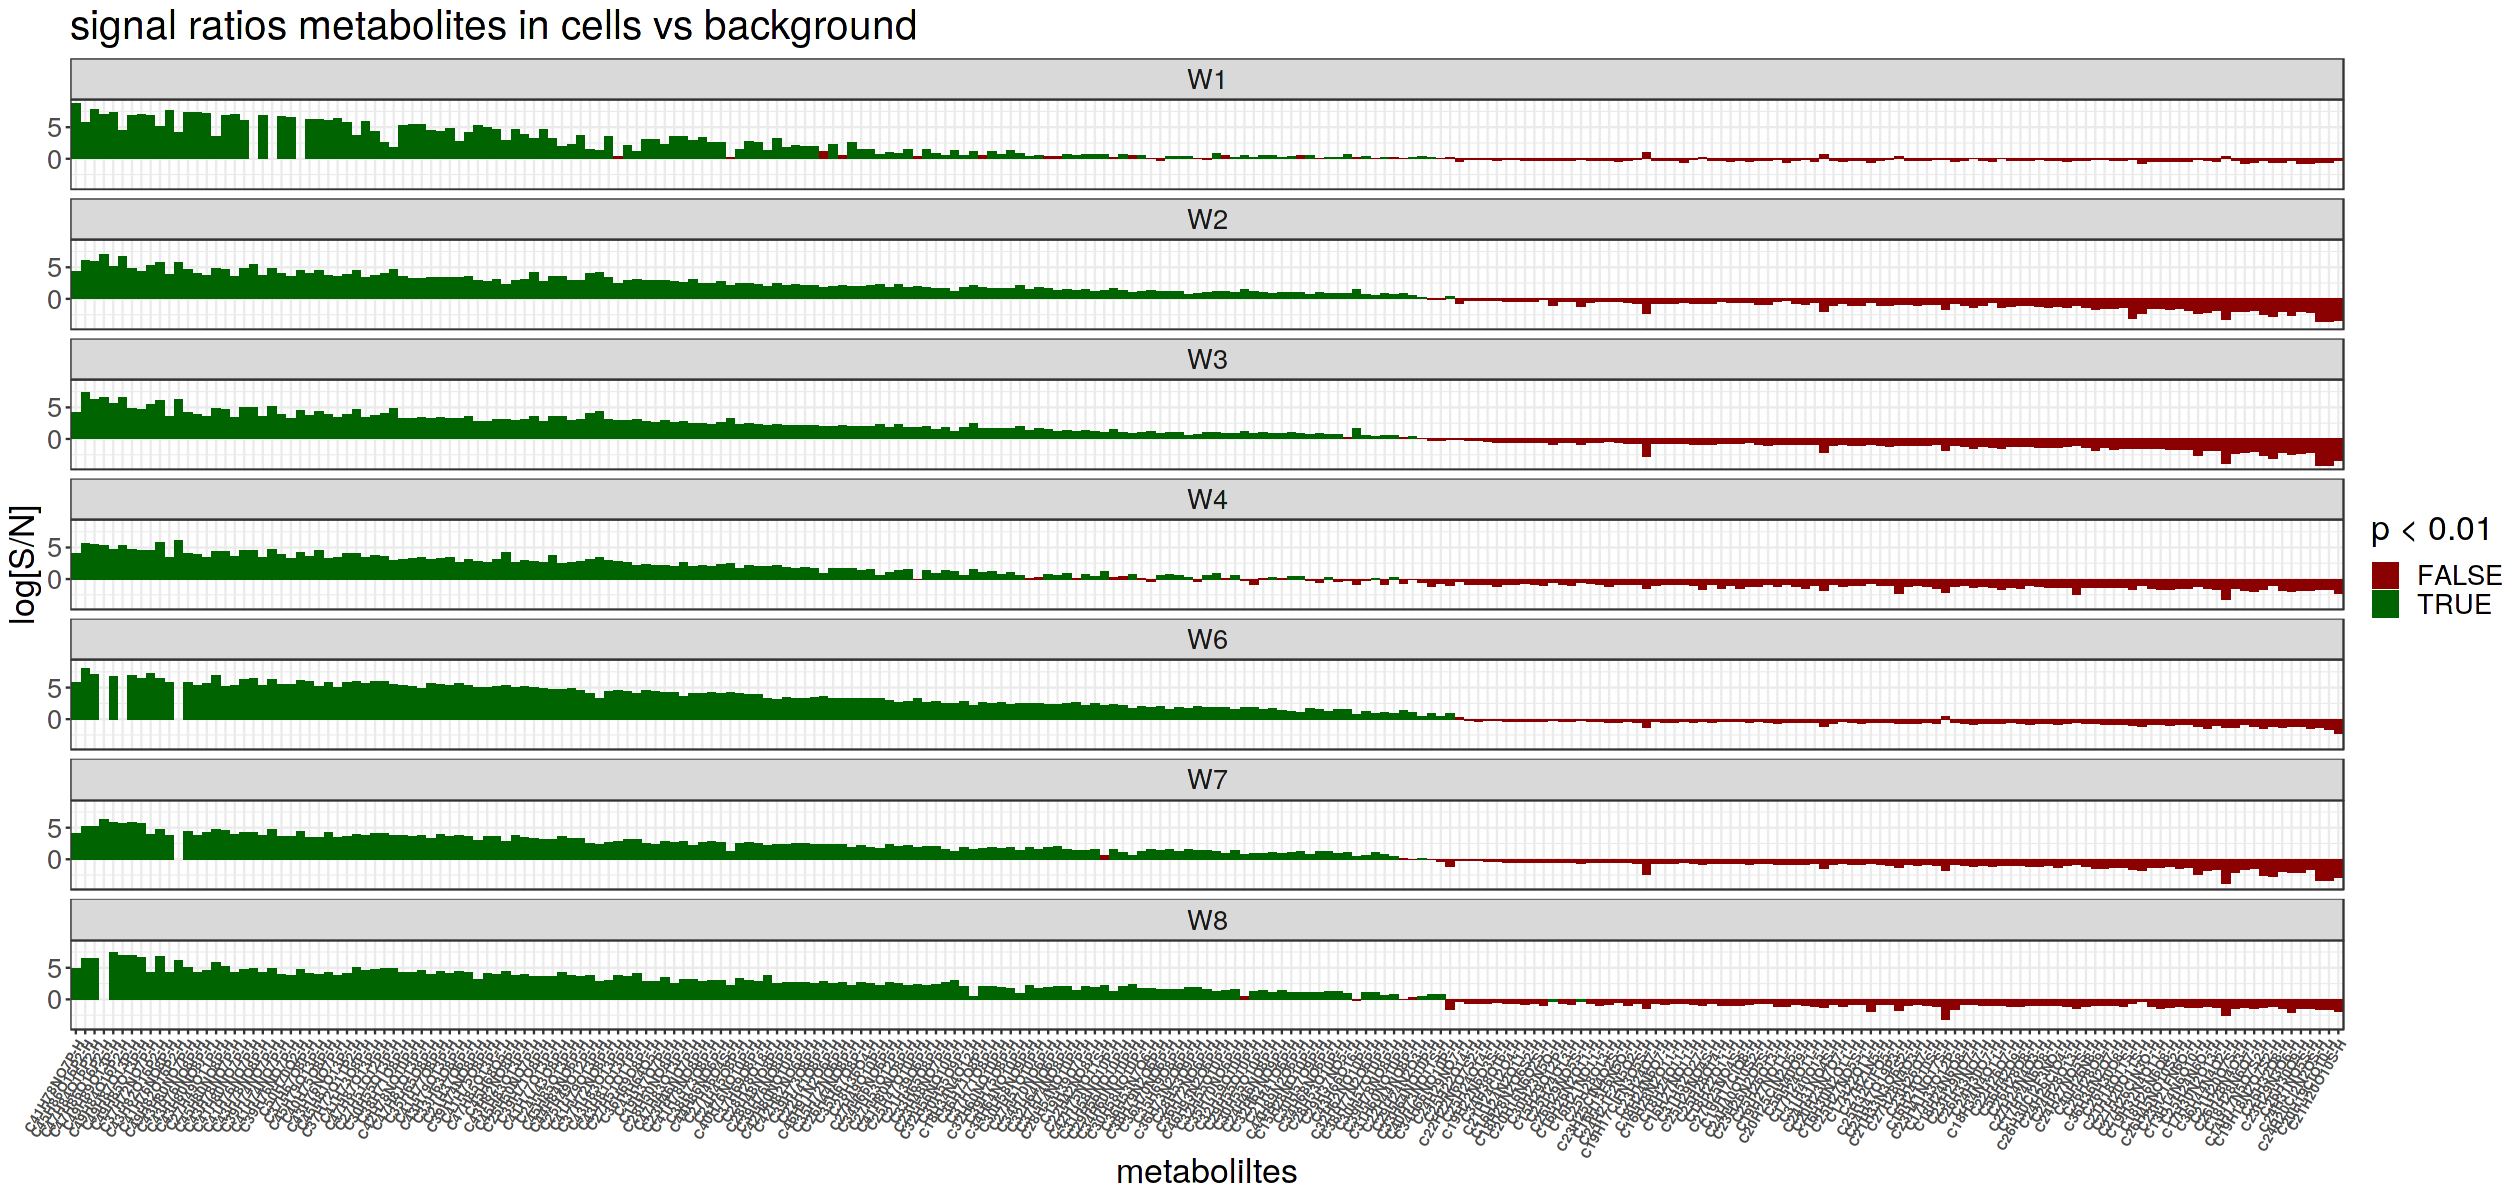

In [15]:
options(repr.plot.width=21, repr.plot.height=10)

ggplot(formula_adduct_cell_signals, aes(x = formula_adduct, fill = p_values > -log(base = 10, 0.01)))+
  geom_bar(stat = "identity",aes(y = log(s_n)), position = "dodge")+
  facet_wrap(~well, ncol = 1)+
  theme_bw()+
  scale_fill_manual(values = c("darkred", "darkgreen"))+
  labs(title = "signal ratios metabolites in cells vs background", y = "log[S/N]", x = "metaboliltes", fill = "p < 0.01")+
  theme_bw()+
  theme(text = element_text(size = 20))+
  theme(axis.text.x = element_text(angle = 60, size = 8, face = "bold",hjust = 1))

### list of metabolites with p < 0.01 and a mean log S/N of at least 2

In [16]:
print(
    formula_adduct_cell_signals  %>%  group_by(formula_adduct) %>% 
              summarise(mean = mean(s_n, na.rm = T), p_values = mean(p_values, na.rm = T)) %>% 
              filter(mean > 2, p_values > -log(base = 10, 0.01)) %>% 
              pull(formula_adduct)
    )


  [1] C41H78NO7P-H  C45H86O16P2-H C47H84O16P2-H C47H86O16P2-H C49H89O13P-H 
  [6] C49H84O16P2-H C49H87O13P-H  C49H85O13P-H  C37H72NO7P-H  C43H82O16P2-H
 [11] C41H76NO8P-H  C49H82O16P2-H C43H80NO7P-H  C43H76NO8P-H  C43H80NO8P-H 
 [16] C27H49O11P-H  C45H80NO8P-H  C43H78NO7P-H  C41H80NO7P-H  C41H76NO7P-H 
 [21] C43H78NO8P-H  C39H74NO7P-H  C41H74NO7P-H  C39H76NO7P-H  C50H70O2-H   
 [26] C37H67O8P-H   C45H79O13P-H  C40H75O8P-H   C43H76NO7P-H  C45H81O13P-H 
 [31] C37H72O11P2-H C41H73O8P-H   C47H87O13P-H  C27H51O12P-H  C30H55O13P-H 
 [36] C38H71O8P-H   C42H78NO10P-H C47H81O13P-H  C35H65O8P-H   C41H77O8P-H  
 [41] C43H79O13P-H  C33H63O8P-H   C21H37O6P-H   C39H74NO8P-H  C41H75O8P-H  
 [46] C47H85O13P-H  C45H68O5-H    C43H82NO8P-H  C45H83O13P-H  C25H50NO7P-H 
 [51] C39H71O8P-H   C41H77O13P-H  C24H43O8P-H   C45H85O13P-H  C44H84NO6P-H 
 [56] C25H49O12P-H  C41H79O13P-H  C37H72NO8P-H  C43H83O13P-H  C43H81O13P-H 
 [61] C27H51O11P-H  C36H69O8P-H   C43H64O5-H    C19H37O7P-H   C28H50NO8P-H 
 [66] C47H83

## QC on vs. off sampling

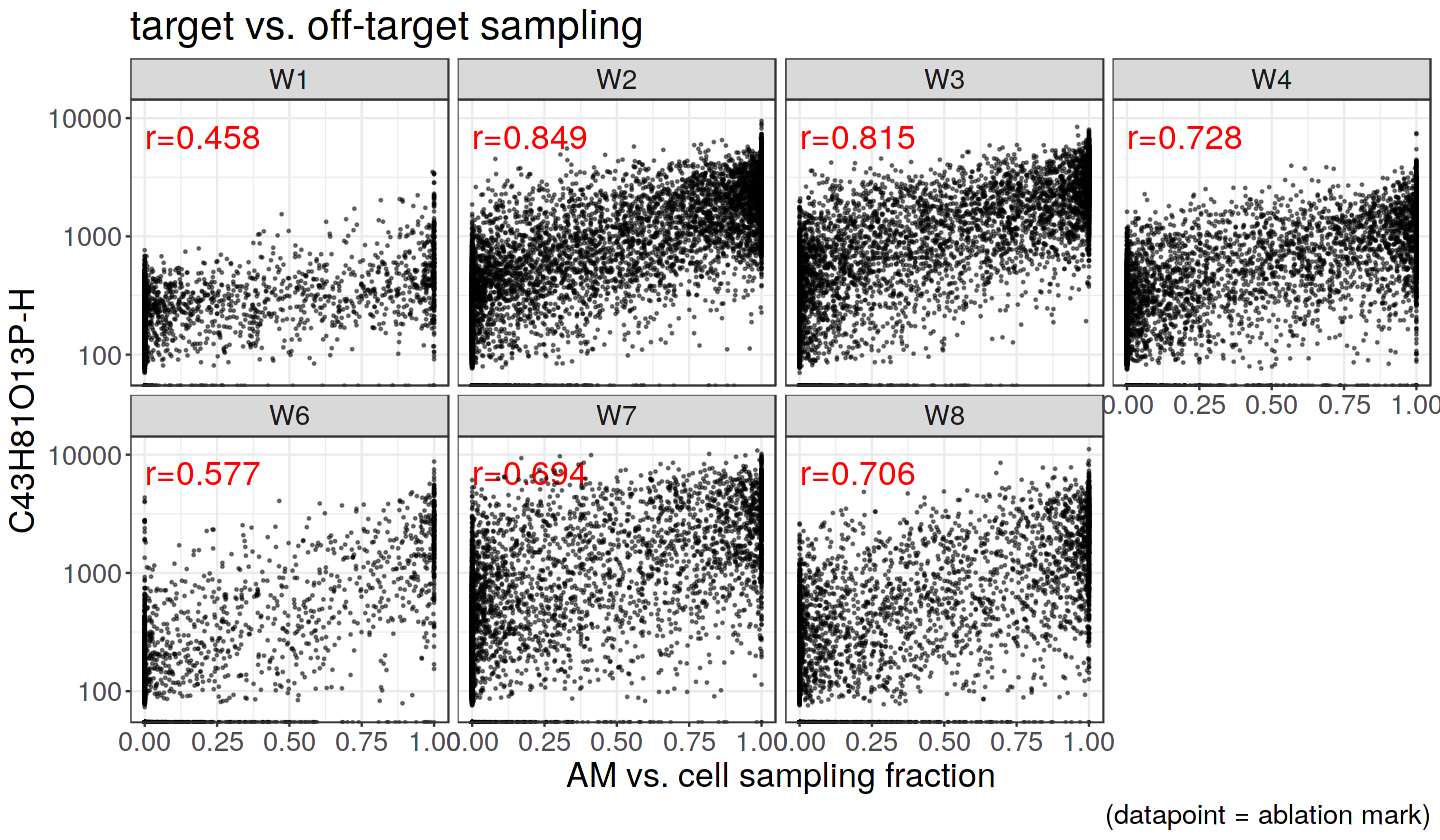

In [17]:
options(repr.plot.width=12, repr.plot.height=7)

ggplot(data = abl_matrix, aes(x = am_sampling_ratio, y = `C43H81O13P-H`))+
  scale_y_log10()+
  geom_text(
    data    = abl_matrix %>% group_by(well) %>% 
      summarise(r = cor(am_sampling_ratio, `C43H81O13P-H`, method = "spearman")),
    mapping = aes(x = 0, y = 9000, label = paste0("r=",round(r, digits = 3))),
    hjust   = 0,
    vjust   = 1, size = 7,
    col = "red"
  )+
  geom_point(alpha = .5, size = .3)+
  labs(x = "AM vs. cell sampling fraction", title = "target vs. off-target sampling", 
       caption = "(datapoint = ablation mark)")+
  stat_summary(fun="median",geom="crossbar")+
  facet_wrap(~well, ncol = 4)+
  theme_bw()+
  theme(text = element_text(size = 20))

### thoughts about the above figure:
 * x-axis contain sampling ratios: ablation mark with x = 0 have no overlap with cells, abl marks with x = 1 are fully cell associated 
 * the (red) spearman correlations could be used as a quality control measure to select wells that are of sufficient technical quality to proceed analysis
 * lower delocalization will lead to higher correlations
 * also, segmentation quality will affect the correlations (better segmenation, higher r) 
 * note that the y-axis is logarithmic! this migh mean that cell normalization might improve when log-transformation might be done _before_ normalization


## Delocalization QC

* the distance _D_ to the closest cell in micron is calculated for all ablation marks

In [18]:
distance <- function(x1, x2, y1, y2){
  sqrt(
    ((x1-x2)^2) + ((y1-y2)^2)
  )
}


abl_matrix_w_dist <-
do.call("rbind",
sapply(unique(sc_matrix$well), function(well_i){
  p <- subset(sc_matrix, well == well_i)
  q <- subset(abl_matrix, well == well_i)
  cross_matrix <-
    sapply(seq_along(p), function(sc_i){
      distance(x1 = p[sc_i,]$center_x,
               y1 = p[sc_i,]$center_y, 
               x2 =q$center_x,
               y2 = q$center_y
      )
      
    })
  q$min_dist_to_cell <- apply(cross_matrix, 1, function(j){min(j, na.rm = T)})
  q
}, simplify = FALSE))



* metabolite signal is expressed as a function of distance _D_
* sampling ratio of ablation mark (0-1) is color coded in red
* wells with low delocalization for the given metabolite are expected the have much lower signals when ablation marks are shifting for red to gray

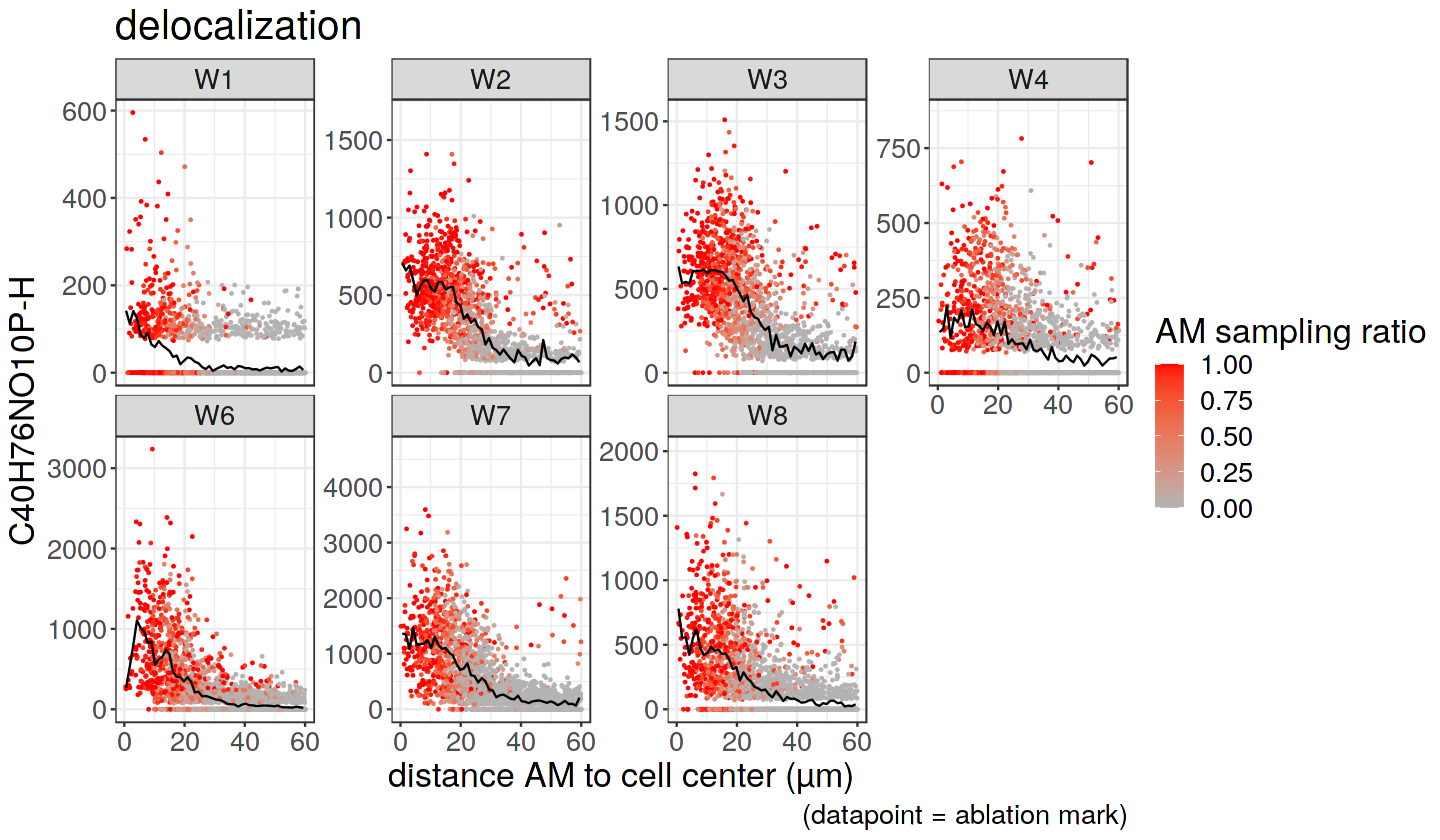

In [19]:
ggplot(data = abl_matrix_w_dist, 
       aes(x = min_dist_to_cell/px_per_um, 
           color = am_sampling_ratio, 
           y = `C40H76NO10P-H`))+ 
   geom_point(size = .3)+
  stat_summary_bin(fun = "mean", geom="line", bins=50, color = "black", linetype = 1) +
  scale_color_gradient(low = "gray70", high = "red")+
  scale_x_continuous(limits = c(0,60))+
  labs(title = "delocalization", 
       x = "distance AM to cell center (µm)", color = "AM sampling ratio", 
       caption = "(datapoint = ablation mark)")+
  facet_wrap(~well, ncol = 4, scales = "free_y")+
  theme_bw()+
  theme(text = element_text(size = 20))